In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler
import warnings
from fbprophet import Prophet

%matplotlib inline
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv('data/zillow_data.csv')
lumber = pd.read_csv('data/plywood_prices.csv')
concrete = pd.read_csv('data/concrete_prices.csv')
income = pd.read_csv('data/Median_household_income.csv')
df_1 = pd.read_csv('data/new_zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [10]:
try:
    df_1.drop(['StateName', 'RegionType'], axis = 1, inplace=True)
except:
    pass
df_1.head()

,RegionID,SizeRank,RegionName,State,City,Metro,CountyName,1996-01-31,1996-02-29,1996-03-31,...,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31
0,61639,0,10025,NY,New York,New York-Newark-Jersey City,New York County,193814.0,192607.0,192672.0,...,1036773.0,1039292.0,1051475.0,1052389.0,1062227.0,1073321.0,1088262.0,1101458.0,1110816.0,1117997.0
1,84654,1,60657,IL,Chicago,Chicago-Naperville-Elgin,Cook County,262402.0,261715.0,260704.0,...,497434.0,499976.0,502451.0,504692.0,507078.0,508667.0,510851.0,513170.0,516360.0,519384.0
2,61637,2,10023,NY,New York,New York-Newark-Jersey City,New York County,261664.0,261719.0,261863.0,...,1105905.0,1101323.0,1092186.0,1083389.0,1083178.0,1081122.0,1084203.0,1086301.0,1088716.0,1088755.0
3,91982,3,77494,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,201649.0,201899.0,201700.0,...,345982.0,349035.0,353498.0,358004.0,363402.0,369313.0,376254.0,383839.0,392947.0,403712.0
4,84616,4,60614,IL,Chicago,Chicago-Naperville-Elgin,Cook County,353678.0,352681.0,351341.0,...,635561.0,638519.0,641360.0,643819.0,646973.0,649403.0,652545.0,654806.0,658509.0,661889.0


In [3]:
lumber.rename({'WPU083': 'plywood prices', 'DATE': 'time'}, axis=1, inplace=True)
lumber

,time,plywood prices
0,2003-12-01,192.1
1,2004-01-01,174.4
2,2004-02-01,202.5
3,2004-03-01,218.5
4,2004-04-01,222.6
...,...,...
168,2017-12-01,218.1
169,2018-01-01,219.8
170,2018-02-01,227.9
171,2018-03-01,236.5


In [4]:
concrete.rename({'PCU32733273': 'concrete prices', 'DATE' : 'time'}, axis = 1, inplace = True)
concrete

,time,concrete prices
0,2003-12-01,100.0
1,2004-01-01,100.9
2,2004-02-01,101.7
3,2004-03-01,101.7
4,2004-04-01,102.4
...,...,...
168,2017-12-01,164.3
169,2018-01-01,165.8
170,2018-02-01,166.1
171,2018-03-01,168.9


In [5]:
income.rename({'MEHOINUSA672N': 'median_house_inc', 'DATE' : 'time'}, axis=1, inplace=True)
income

,time,median_house_inc
0,1996-01-01,57772
1,1997-01-01,58961
2,1998-01-01,61128
3,1999-01-01,62641
4,2000-01-01,62512
5,2001-01-01,61126
6,2002-01-01,60435
7,2003-01-01,60360
8,2004-01-01,60150
9,2005-01-01,60794


In [6]:
def get_datetimes(df):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    return pd.to_datetime(df.columns.values[7:], format='%Y-%m')

In [11]:
def melt_data(df, compress = False):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    
    If compress is True will compress data to only the value column.
    """
    if compress == True:
        melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 
                                      'Metro', 'CountyName'], var_name='time')
        melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
        melted = melted.dropna(subset=['value'])
        return melted.groupby('time').aggregate({'value':'mean'})
    else:
        melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 
                                      'Metro', 'CountyName'], var_name='time')
        melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
        melted = melted.dropna(subset=['value'])
        return melted

In [12]:
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Takes in the y_true values and the y_pred and will
    return the mean absolute error as a percent
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [13]:
def plot_series(df, name = None, window = None, X = None, y = None, x_label = None, y_label = None):
    '''
    Will plot dataframe, rolling mean, rolling std of a given dataframe
    
    Parameters
    ------------
    df : The dataframe you with to plot
    name : The name of the plot
    window : The window of the rolling values
    X : length of the df
    y : height of the df
    x_label : The X-axis label
    y_label : The y-axis label
    
    Returns
    -----------
    Plot of the Original data, the rolling mean, and the rolling standard deviation
    '''
    df_mean = df.rolling(window=window).mean()
    df_std = df.rolling(window=window).std()

    fig, ax = plt.subplots(figsize = (X,y))

    orig = plt.plot(df, label = 'Original')
    mean = plt.plot(df_mean, label = 'Rolling Mean')
    std = plt.plot(df_std, label = 'Rolling Std')
    plt.title(name)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(loc = 'best')
    plt.show();

In [14]:
def seasonal_plot(df, window = None, X = None, y = None):
    '''
    Plotting the seasonal decompose
    
    Parameters
    -----------
    df : The dataframe you wish to decompose
    window : The rolling window
    X : The length of the plot
    y : The Height of the plot
    
    Return 
    -----------
    A seasonal decompose of the dataframe. 
    '''
    result = seasonal_decompose(df.rolling(window).mean().dropna())
    plt.rcParams['figure.figsize'] = (X,y)
    result.plot();

In [15]:
def adfuller_test(df, name = None):
    '''
    Take a dataframe or series and returns the adfuller test for it.
    
    Parameters
    -----------
    df : dataframe or series
    name = Name of the variable you are testing
    '''
    df_test = adfuller(df)
    print(f'Adfuller test for {name}')
    print('-'*20)
    print('Test Stastic = {:.3f}'.format(df_test[0]))
    print('P-value = {:.3f}'.format(df_test[1]))
    print('Critical values :')
    for k, v in df_test[4].items():
        print(f"{k}: {v} - The data is {'not' if v < df_test[0] else ''} stationary with {100 - int(k[:-1])}% confidence")

In [16]:
def kpss_test(df, name = None):
    '''
    Will return the kpss test
    
    Parmeters
    ----------
    df = dataframe or series
    name = Name of the variable you are testing
    '''
    df_test = kpss(np.log(df), nlags='auto')
    print(f'Is {name} data stationary?')
    print(f'Test stastic = {df_test[0]: .3f}')
    print(f'P-value = {df_test[1]: .3f}')
    print('Critical Values: ')
    for k, v in df_test[3].items():
        print(f'{k}: {v}')

In [17]:
df_melt = melt_data(df)
df_melt.head()

,RegionName,RegionID,SizeRank,City,State,Metro,CountyName,time,value
0,60657,84654,1,Chicago,IL,Chicago,Cook,1996-04-01,334200.0
1,75070,90668,2,McKinney,TX,Dallas-Fort Worth,Collin,1996-04-01,235700.0
2,77494,91982,3,Katy,TX,Houston,Harris,1996-04-01,210400.0
3,60614,84616,4,Chicago,IL,Chicago,Cook,1996-04-01,498100.0
4,79936,93144,5,El Paso,TX,El Paso,El Paso,1996-04-01,77300.0


In [18]:
df_melt.tail()

,RegionName,RegionID,SizeRank,City,State,Metro,CountyName,time,value
3901590,1338,58333,14719,Ashfield,MA,Greenfield Town,Franklin,2018-04-01,209300.0
3901591,3293,59107,14720,Woodstock,NH,Claremont,Grafton,2018-04-01,225800.0
3901592,40404,75672,14721,Berea,KY,Richmond,Madison,2018-04-01,133400.0
3901593,81225,93733,14722,Mount Crested Butte,CO,NaN,Gunnison,2018-04-01,664400.0
3901594,89155,95851,14723,Mesquite,NV,Las Vegas,Clark,2018-04-01,357200.0


In [19]:
df_melt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3744704 entries, 0 to 3901594
Data columns (total 9 columns):
 #   Column      Dtype         
---  ------      -----         
 0   RegionName  int64         
 1   RegionID    int64         
 2   SizeRank    int64         
 3   City        object        
 4   State       object        
 5   Metro       object        
 6   CountyName  object        
 7   time        datetime64[ns]
 8   value       float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 285.7+ MB


In [20]:
df_melt.time.min(), df_melt.time.max()

(Timestamp('1996-04-01 00:00:00'), Timestamp('2018-04-01 00:00:00'))

In [21]:
df_melt_1 = melt_data(df_1)
df_melt_1.head()

,RegionName,RegionID,SizeRank,City,State,Metro,CountyName,time,value
0,10025,61639,0,New York,NY,New York-Newark-Jersey City,New York County,1996-01-31,193814.0
1,60657,84654,1,Chicago,IL,Chicago-Naperville-Elgin,Cook County,1996-01-31,262402.0
2,10023,61637,2,New York,NY,New York-Newark-Jersey City,New York County,1996-01-31,261664.0
3,77494,91982,3,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,1996-01-31,201649.0
4,60614,84616,4,Chicago,IL,Chicago-Naperville-Elgin,Cook County,1996-01-31,353678.0


In [22]:
df_melt_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7650220 entries, 0 to 9467572
Data columns (total 9 columns):
 #   Column      Dtype         
---  ------      -----         
 0   RegionName  int64         
 1   RegionID    int64         
 2   SizeRank    int64         
 3   City        object        
 4   State       object        
 5   Metro       object        
 6   CountyName  object        
 7   time        datetime64[ns]
 8   value       float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 583.7+ MB


In [23]:
df_melt_1.time.min(), df_melt_1.time.max()

(Timestamp('1996-01-31 00:00:00'), Timestamp('2021-07-31 00:00:00'))

### Merging the data together

In [24]:
melt_df= melt_data(df, compress=False)

In [25]:
melt_df.set_index('time', inplace=True)

In [26]:
melt_df = melt_df[melt_df.index >= '2003-12-01']

In [27]:
melt_df

,RegionName,RegionID,SizeRank,City,State,Metro,CountyName,value
time,,,,,,,,
2003-12-01,60657,84654,1,Chicago,IL,Chicago,Cook,752300.0
2003-12-01,75070,90668,2,McKinney,TX,Dallas-Fort Worth,Collin,187100.0
2003-12-01,77494,91982,3,Katy,TX,Houston,Harris,229600.0
2003-12-01,60614,84616,4,Chicago,IL,Chicago,Cook,1012600.0
2003-12-01,79936,93144,5,El Paso,TX,El Paso,El Paso,83400.0
...,...,...,...,...,...,...,...,...
2018-04-01,1338,58333,14719,Ashfield,MA,Greenfield Town,Franklin,209300.0
2018-04-01,3293,59107,14720,Woodstock,NH,Claremont,Grafton,225800.0
2018-04-01,40404,75672,14721,Berea,KY,Richmond,Madison,133400.0


In [28]:
lumber.isna().sum()

time              0
plywood prices    0
dtype: int64

In [29]:
concrete.isna().sum()

time               0
concrete prices    0
dtype: int64

In [30]:
try:
    con_lum = concrete.merge(lumber, on = 'time')
except:
    pass
con_lum['time'] = pd.to_datetime(con_lum['time'])
con_lum.isna().sum()

time               0
concrete prices    0
plywood prices     0
dtype: int64

In [31]:
income['time'] = pd.to_datetime(income['time'])
income.time

0    1996-01-01
1    1997-01-01
2    1998-01-01
3    1999-01-01
4    2000-01-01
5    2001-01-01
6    2002-01-01
7    2003-01-01
8    2004-01-01
9    2005-01-01
10   2006-01-01
11   2007-01-01
12   2008-01-01
13   2009-01-01
14   2010-01-01
15   2011-01-01
16   2012-01-01
17   2013-01-01
18   2014-01-01
19   2015-01-01
20   2016-01-01
21   2017-01-01
22   2018-01-01
23   2019-01-01
Name: time, dtype: datetime64[ns]

In [32]:
try:
    income.set_index('time', inplace=True)
except:
    pass
income = income.resample('MS').ffill()
income = income.reset_index()
income.isna().sum()

time                0
median_house_inc    0
dtype: int64

In [33]:
try:
    final_3 = con_lum.merge(income, on='time')
except:
    pass
final_3.isna().sum()

time                0
concrete prices     0
plywood prices      0
median_house_inc    0
dtype: int64

In [34]:
final_3.set_index('time', inplace=True)
final_3

,concrete prices,plywood prices,median_house_inc
time,,,
2003-12-01,100.0,192.1,60360
2004-01-01,100.9,174.4,60150
2004-02-01,101.7,202.5,60150
2004-03-01,101.7,218.5,60150
2004-04-01,102.4,222.6,60150
...,...,...,...
2017-12-01,164.3,218.1,63761
2018-01-01,165.8,219.8,64324
2018-02-01,166.1,227.9,64324


In [35]:
final_df = melt_df.join(final_3)#pd.concat([melt_df, final_3], axis=1)
final_df

,RegionName,RegionID,SizeRank,City,State,Metro,CountyName,value,concrete prices,plywood prices,median_house_inc
time,,,,,,,,,,,
2003-12-01,60657,84654,1,Chicago,IL,Chicago,Cook,752300.0,100.0,192.1,60360
2003-12-01,75070,90668,2,McKinney,TX,Dallas-Fort Worth,Collin,187100.0,100.0,192.1,60360
2003-12-01,77494,91982,3,Katy,TX,Houston,Harris,229600.0,100.0,192.1,60360
2003-12-01,60614,84616,4,Chicago,IL,Chicago,Cook,1012600.0,100.0,192.1,60360
2003-12-01,79936,93144,5,El Paso,TX,El Paso,El Paso,83400.0,100.0,192.1,60360
...,...,...,...,...,...,...,...,...,...,...,...
2018-04-01,1338,58333,14719,Ashfield,MA,Greenfield Town,Franklin,209300.0,169.0,236.6,64324
2018-04-01,3293,59107,14720,Woodstock,NH,Claremont,Grafton,225800.0,169.0,236.6,64324
2018-04-01,40404,75672,14721,Berea,KY,Richmond,Madison,133400.0,169.0,236.6,64324


# TIme Series Analysis - LSTM

In [36]:
Denver_df = final_df[final_df['RegionName'] == 80216]
Vallejo_df = final_df[final_df['RegionName'] == 94590]
Atlanta_df = final_df[final_df['RegionName'] == 30316]
Miami_gard_df = final_df[final_df['RegionName'] == 33055]
Miami_df = final_df[final_df['RegionName'] == 33135]

## Denver

In [37]:
Denver_df

,RegionName,RegionID,SizeRank,City,State,Metro,CountyName,value,concrete prices,plywood prices,median_house_inc
time,,,,,,,,,,,
2013-01-01,80216,93292,7303,Denver,CO,Denver,Denver,91800.0,140.0,198.2,58904
2013-02-01,80216,93292,7303,Denver,CO,Denver,Denver,93300.0,140.1,200.7,58904
2013-03-01,80216,93292,7303,Denver,CO,Denver,Denver,95000.0,140.2,204.7,58904
2013-04-01,80216,93292,7303,Denver,CO,Denver,Denver,97600.0,141.4,207.9,58904
2013-05-01,80216,93292,7303,Denver,CO,Denver,Denver,100900.0,141.5,206.8,58904
...,...,...,...,...,...,...,...,...,...,...,...
2017-12-01,80216,93292,7303,Denver,CO,Denver,Denver,251200.0,164.3,218.1,63761
2018-01-01,80216,93292,7303,Denver,CO,Denver,Denver,253800.0,165.8,219.8,64324
2018-02-01,80216,93292,7303,Denver,CO,Denver,Denver,258100.0,166.1,227.9,64324


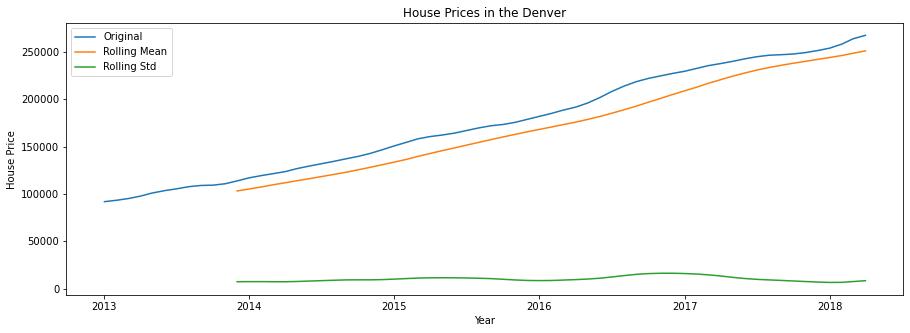

In [38]:
denver = Denver_df[['value']]
plot_series(denver, name='House Prices in the Denver', window=12,
            X = 15,
            y = 5,
            x_label= 'Year',
            y_label='House Price')

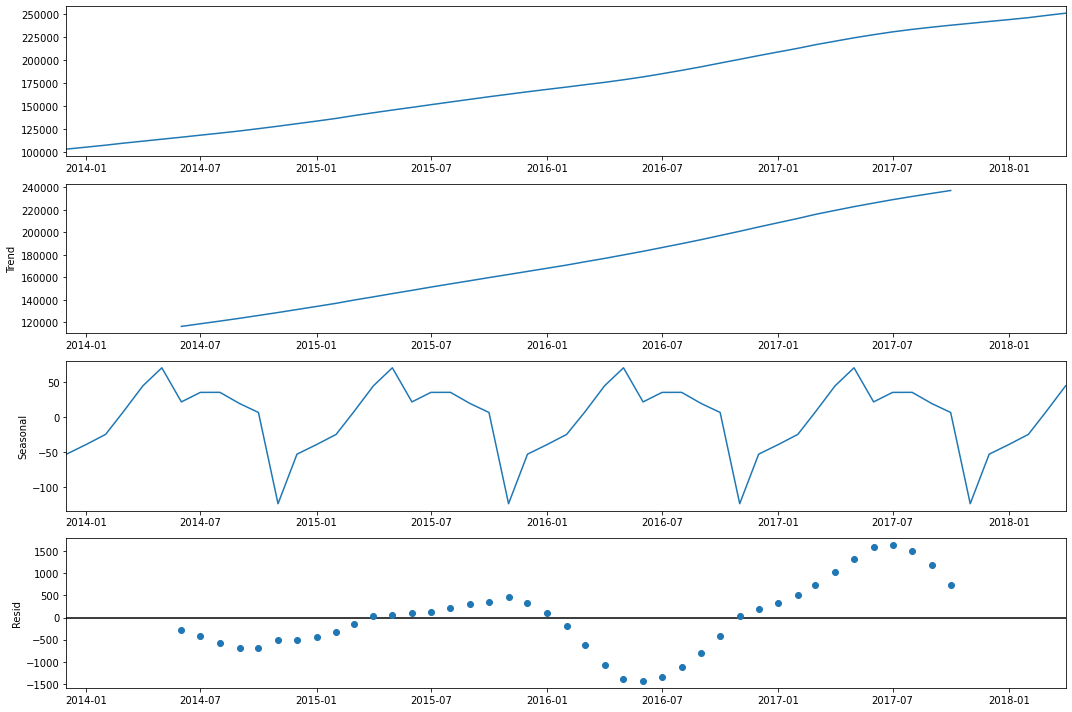

In [39]:
seasonal_plot(denver, window=12, X = 15, y = 10)

In [40]:
adfuller_test(denver, name='Denver Prices')

Adfuller test for Denver Prices
--------------------
Test Stastic = 0.221
P-value = 0.973
Critical values :
1%: -3.5443688564814813 - The data is not stationary with 99% confidence
5%: -2.9110731481481484 - The data is not stationary with 95% confidence
10%: -2.5931902777777776 - The data is not stationary with 90% confidence


In [41]:
kpss_test(denver, name = 'Denver Prices')

Is Denver Prices data stationary?
Test stastic =  1.167
P-value =  0.010
Critical Values: 
10%: 0.347
5%: 0.463
2.5%: 0.574
1%: 0.739


C:\Users\Manav Kahlon\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [42]:
Denver_df

,RegionName,RegionID,SizeRank,City,State,Metro,CountyName,value,concrete prices,plywood prices,median_house_inc
time,,,,,,,,,,,
2013-01-01,80216,93292,7303,Denver,CO,Denver,Denver,91800.0,140.0,198.2,58904
2013-02-01,80216,93292,7303,Denver,CO,Denver,Denver,93300.0,140.1,200.7,58904
2013-03-01,80216,93292,7303,Denver,CO,Denver,Denver,95000.0,140.2,204.7,58904
2013-04-01,80216,93292,7303,Denver,CO,Denver,Denver,97600.0,141.4,207.9,58904
2013-05-01,80216,93292,7303,Denver,CO,Denver,Denver,100900.0,141.5,206.8,58904
...,...,...,...,...,...,...,...,...,...,...,...
2017-12-01,80216,93292,7303,Denver,CO,Denver,Denver,251200.0,164.3,218.1,63761
2018-01-01,80216,93292,7303,Denver,CO,Denver,Denver,253800.0,165.8,219.8,64324
2018-02-01,80216,93292,7303,Denver,CO,Denver,Denver,258100.0,166.1,227.9,64324


In [43]:
Denver_lstm = Denver_df.drop(['RegionName', 'RegionID', 'SizeRank', 'City', 'Metro',
                              'CountyName', 'State'], axis=1)
Denver_lstm.reset_index(inplace=True)
train_dates = Denver_lstm.time
cols = list(Denver_lstm)[1:]
denver_for_train = Denver_df[cols].astype(float)
scaler = StandardScaler()
denver_for_train_scaled = scaler.fit_transform(denver_for_train)

trainX = []
trainY = []

n_future = 1
n_past = 6

for i in range(n_past, len(denver_for_train_scaled) - n_future + 1):
    trainX.append(denver_for_train_scaled[i - n_past:i, 0:denver_for_train.shape[1]])
    trainY.append(denver_for_train_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)
print(f'trainX shape == {trainX.shape}')
print(f'trainY shape == {trainY.shape}')

trainX shape == (58, 6, 4)
trainY shape == (58, 1)


In [44]:
model = Sequential()
model.add(LSTM(64, activation = 'relu', input_shape = (trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation = 'relu', return_sequences=True))
model.add(LSTM(16, activation = 'relu', return_sequences = False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss = 'mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6, 64)             17664     
_________________________________________________________________
lstm_1 (LSTM)                (None, 6, 32)             12416     
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 33,233
Trainable params: 33,233
Non-trainable params: 0
_________________________________________________________________


In [45]:
history = model.fit(trainX, trainY, epochs=200, batch_size = 5, validation_split=.1, verbose = 0, use_multiprocessing=True)

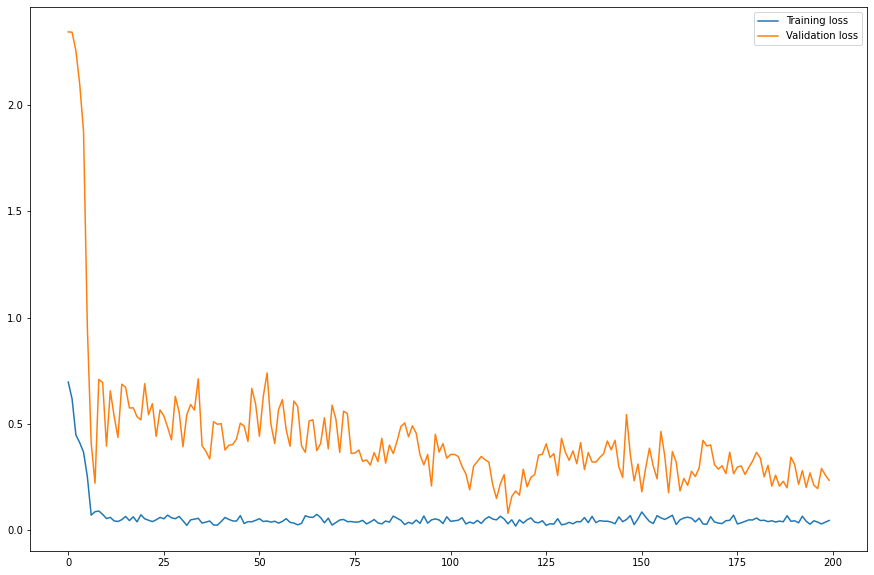

In [46]:
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.legend();

In [47]:
n_past = 6
n_days_for_predictions = 58
forecast_period_dates = pd.date_range(list(train_dates)[n_past], periods=n_days_for_predictions, freq='MS').to_list()
forecast = model.predict(trainX[-n_days_for_predictions:])

forecast_copies = np.repeat(forecast, denver_for_train.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'time' : np.array(forecast_dates), 'value': y_pred_future})
df_forecast['time'] = pd.to_datetime(df_forecast['time'])

original = Denver_lstm[['time', 'value']]

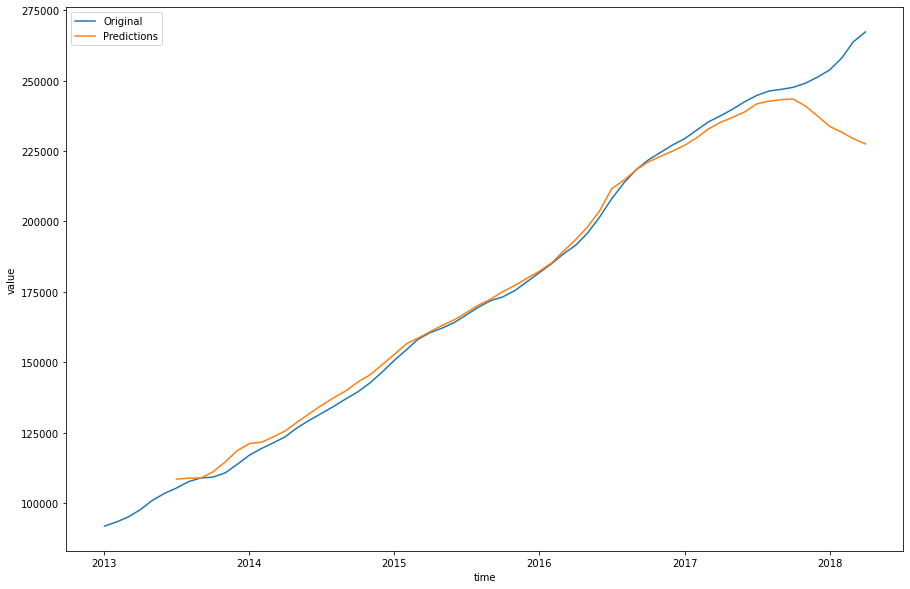

In [48]:
sns.lineplot(original['time'], original['value'], label = 'Original')
sns.lineplot(df_forecast['time'], df_forecast['value'], label = 'Predictions')
plt.legend();

In [49]:
df_prophet = Denver_lstm.rename({'time': 'ds', 'value': 'y'}, axis=1)
df_prophet.drop(['concrete prices', 'plywood prices',
                 'median_house_inc'], inplace=True, axis=1)

In [50]:
model = Prophet()
model.fit(df_prophet)
forecast = model.predict(df_prophet)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


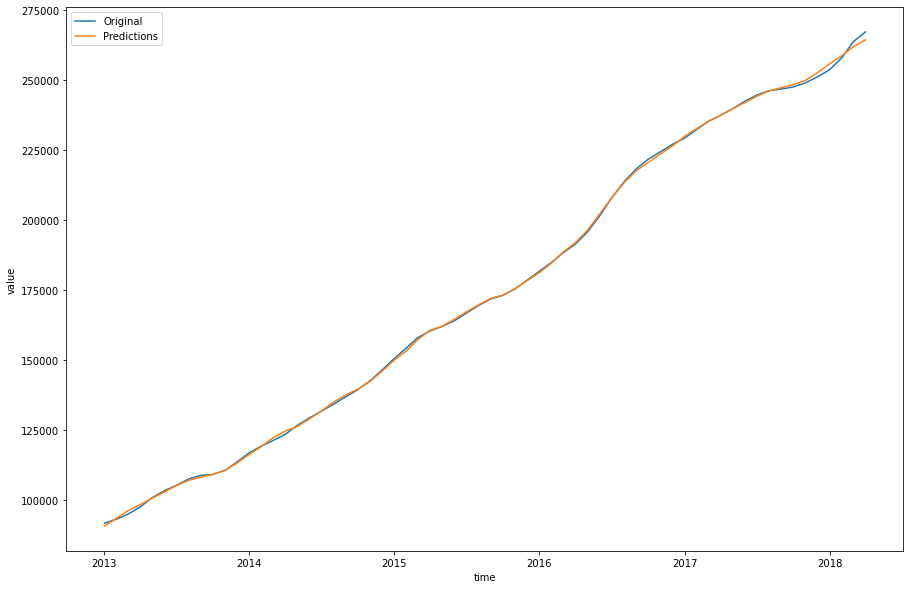

In [51]:
sns.lineplot(original['time'], original['value'], label = 'Original')
sns.lineplot(forecast['ds'], forecast['yhat'], label = 'Predictions');

In [52]:
MSE = np.square(np.subtract(original.value,forecast.yhat)).mean() 
 
RMSE = math.sqrt(MSE)
print(f'RMSE: {RMSE}')
print("%RMSE: ", RMSE/original.mean())

RMSE: 756.7257947165508
%RMSE:  value    0.004326
dtype: float64


In [53]:
future = model.make_future_dataframe(periods=36, freq='MS')
future_forecast = model.predict(future)

In [55]:
df_melt_1

,RegionName,RegionID,SizeRank,City,State,Metro,CountyName,time,value
0,10025,61639,0,New York,NY,New York-Newark-Jersey City,New York County,1996-01-31,193814.0
1,60657,84654,1,Chicago,IL,Chicago-Naperville-Elgin,Cook County,1996-01-31,262402.0
2,10023,61637,2,New York,NY,New York-Newark-Jersey City,New York County,1996-01-31,261664.0
3,77494,91982,3,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,1996-01-31,201649.0
4,60614,84616,4,Chicago,IL,Chicago-Naperville-Elgin,Cook County,1996-01-31,353678.0
...,...,...,...,...,...,...,...,...,...
9467568,72630,89666,34430,Diamond City,AR,Harrison,Boone County,2021-07-31,114784.0
9467569,12345,62532,34430,Central Point,OR,Medford,Jackson County,2021-07-31,165290.0
9467570,66045,87060,34430,Lawrence,KS,Lawrence,Douglas County,2021-07-31,253369.0
9467571,1470,58379,34430,Groton,MA,Boston-Cambridge-Newton,Middlesex County,2021-07-31,423589.0


In [59]:
future = df_melt_1[df_melt_1['RegionName'] == 80216]
future = future[future['time'] >= '2018-04-01']
future.head()

,RegionName,RegionID,SizeRank,City,State,Metro,CountyName,time,value
8241849,80216,93292,7913,Denver,CO,Denver-Aurora-Lakewood,Denver County,2018-04-30,294373.0
8272688,80216,93292,7913,Denver,CO,Denver-Aurora-Lakewood,Denver County,2018-05-31,297772.0
8303527,80216,93292,7913,Denver,CO,Denver-Aurora-Lakewood,Denver County,2018-06-30,300164.0
8334366,80216,93292,7913,Denver,CO,Denver-Aurora-Lakewood,Denver County,2018-07-31,301728.0
8365205,80216,93292,7913,Denver,CO,Denver-Aurora-Lakewood,Denver County,2018-08-31,303761.0


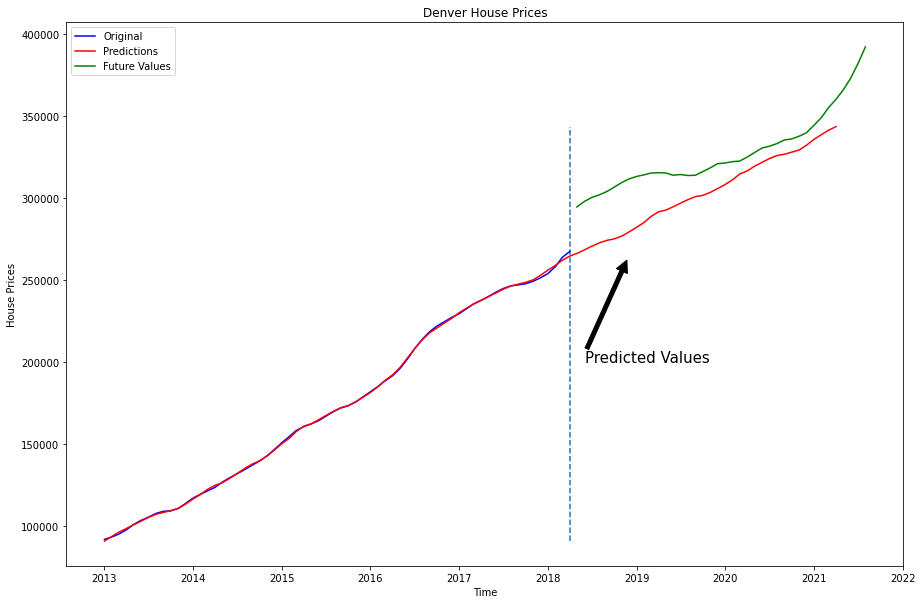

In [60]:
fig, ax = plt.subplots()

x = future_forecast[future_forecast['ds'] == '2018-06-01']['ds']
x_1 = future_forecast[future_forecast['ds'] == '2018-12-01']['ds']

sns.lineplot(original['time'], original['value'],
             label='Original', color='blue')
sns.lineplot(
    future_forecast['ds'], future_forecast['yhat'], label='Predictions', color='r')
sns.lineplot(future['time'], future['value'], label = 'Future Values', color = 'Green')
plt.vlines(x=original['time'].max(), ymin=future_forecast['yhat'].min(
) - 5, ymax=future_forecast['yhat'].max() + 5, linestyles='dashed')
ax.set_title('Denver House Prices')
ax.set_ylabel('House Prices')
ax.set_xlabel('Time')
plt.legend(loc='best')
ax.text(x, 200000, 'Predicted Values', fontsize=15)
ax.annotate('', xy=(x_1, 265000), xytext=(x, 205000),
            arrowprops=dict(facecolor='black', shrink=0.05));

## Vallejo

In [ ]:
Vallejo = Vallejo_df[['value']]
plot_series(Vallejo, name = 'House Prices in Vallejo',
            window=12,
            X = 15, y = 5,
            x_label= 'Year',
            y_label= 'House Prices')

In [ ]:
seasonal_plot(Vallejo, window=13, X = 15, y = 10)

In [ ]:
adfuller_test(Vallejo, 'Vallejo Prices')

In [ ]:
kpss_test(Vallejo, 'Vallejo Prices')

In [ ]:
Vallejo_lstm = Vallejo_df.drop(
    ['RegionName', 'RegionID', 'SizeRank', 'City', 'Metro', 'CountyName', 'State'], axis=1)
Vallejo_lstm.reset_index(inplace=True)
train_dates = Vallejo_lstm.time
cols = list(Vallejo_lstm)[1:]
vallejo_for_train = Vallejo_df[cols].astype(float)
scaler = StandardScaler()
vallejo_for_train_scaled = scaler.fit_transform(vallejo_for_train)

trainX = []
trainY = []

n_future = 1
n_past = 6

for i in range(n_past, len(vallejo_for_train_scaled) - n_future + 1):
    trainX.append(
        vallejo_for_train_scaled[i - n_past:i, 0:vallejo_for_train.shape[1]])
    trainY.append(vallejo_for_train_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)
print(f'trainX shape == {trainX.shape}')
print(f'trainY shape == {trainY.shape}')

In [ ]:
model = Sequential()
model.add(LSTM(64, activation = 'relu', input_shape = (trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation = 'relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss = 'mse')
model.summary()

In [ ]:
history = model.fit(trainX, trainY, epochs=200, batch_size = 5, validation_split=.1, verbose = 0, use_multiprocessing=True)

In [ ]:
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.legend();

In [ ]:
future_val = 167
forecast_period_dates = pd.date_range(list(train_dates)[0], periods=future_val, freq='MS').to_list()
forecast = model.predict(trainX[-future_val:])

forecast_copies = np.repeat(forecast, vallejo_for_train.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'time' : np.array(forecast_dates), 'value': y_pred_future})
df_forecast['time'] = pd.to_datetime(df_forecast['time'])

original = Vallejo_lstm[['time', 'value']]

In [ ]:
sns.lineplot(original['time'], original['value'], label = 'Original')
sns.lineplot(df_forecast['time'], df_forecast['value'], label = 'Predictions')
plt.legend();

In [ ]:
df_prophet = Vallejo_lstm.rename({'time': 'ds', 'value': 'y'}, axis=1)
df_prophet.drop(['concrete prices', 'plywood prices',
                 'median_house_inc'], inplace=True, axis=1)

In [ ]:
model = Prophet()
model.fit(df_prophet)
forecast = model.predict(df_prophet)

In [ ]:
sns.lineplot(original['time'], original['value'], label='Original')
sns.lineplot(forecast['ds'], forecast['yhat'], label='Predictions');

In [ ]:
MSE = np.square(np.subtract(original.value, forecast.yhat)).mean()

In [ ]:
RMSE = math.sqrt(MSE)
print(f'RMSE: {RMSE}')
print("%RMSE: ", RMSE / original.mean())

In [ ]:
future = model.make_future_dataframe(periods=36, freq='MS')
future_forecast = model.predict(future)

In [ ]:
fig, ax = plt.subplots()

x = future_forecast[future_forecast['ds'] == '2018-06-01']['ds']
x_1 = future_forecast[future_forecast['ds'] == '2018-12-01']['ds']

sns.lineplot(original['time'], original['value'],
             label='Original', color='blue')
sns.lineplot(
    future_forecast['ds'], future_forecast['yhat'], label='Predictions', color='r')
plt.vlines(x=original['time'].max(), ymin=future_forecast['yhat'].min(
) - 5, ymax=future_forecast['yhat'].max() + 5, linestyles='dashed')
ax.set_title('Denver House Prices')
ax.set_ylabel('House Prices')
ax.set_xlabel('Time')
plt.legend(loc='best')
ax.text(x, 300000, 'Predicted Values', fontsize=15)
ax.annotate('', xy=(x_1, 380000), xytext=(x, 310000),
            arrowprops=dict(facecolor='black', shrink=0.05));

## Atlanta

In [ ]:
Atlanta = Atlanta_df[['value']]
plot_series(Atlanta, name = 'House Prices in Atlanta',
            window=12,
            X= 15, y = 5,
            x_label= 'Year',
            y_label= 'House Prices')

In [ ]:
seasonal_plot(Atlanta, window=12, X = 15, y = 10)

In [ ]:
adfuller_test(Atlanta, 'Atlanta Prices')

In [ ]:
kpss_test(Atlanta, 'Atlanta Prices')

In [ ]:
atlanta_lstm = Atlanta_df.drop(
    ['RegionName', 'RegionID', 'SizeRank', 'City', 'Metro', 'CountyName', 'State'], axis=1)
atlanta_lstm.reset_index(inplace=True)
train_dates = atlanta_lstm.time
cols = list(atlanta_lstm)[1:]
atlanta_for_train = Atlanta_df[cols].astype(float)
scaler = StandardScaler()
atlanta_for_train_scaled = scaler.fit_transform(atlanta_for_train)

trainX = []
trainY = []

n_future = 1
n_past = 6

for i in range(n_past, len(atlanta_for_train_scaled) - n_future + 1):
    trainX.append(
        atlanta_for_train_scaled[i - n_past:i, 0:atlanta_for_train.shape[1]])
    trainY.append(atlanta_for_train_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)
print(f'trainX shape == {trainX.shape}')
print(f'trainY shape == {trainY.shape}')

In [ ]:
model = Sequential()
model.add(LSTM(64, activation = 'relu', input_shape = (trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation = 'relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss = 'mse')
model.summary()

In [ ]:
history = model.fit(trainX, trainY, epochs=200, batch_size = 5, validation_split=.1, verbose = 0, use_multiprocessing=True)

In [ ]:
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.legend();

In [ ]:
future_val = 167
forecast_period_dates = pd.date_range(
    list(train_dates)[0], periods=future_val, freq='MS').to_list()
forecast = model.predict(trainX[-future_val:])

forecast_copies = np.repeat(forecast, atlanta_for_train.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:, 0]

forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())

df_forecast = pd.DataFrame(
    {'time': np.array(forecast_dates), 'value': y_pred_future})
df_forecast['time'] = pd.to_datetime(df_forecast['time'])

original = atlanta_lstm[['time', 'value']]

In [ ]:
sns.lineplot(original['time'], original['value'], label = 'Original')
sns.lineplot(df_forecast['time'], df_forecast['value'], label = 'Predictions')
plt.legend();

In [ ]:
df_prophet = atlanta_lstm.rename({'time': 'ds', 'value': 'y'}, axis=1)
df_prophet.drop(['concrete prices', 'plywood prices',
                 'median_house_inc'], inplace=True, axis=1)

In [ ]:
model = Prophet()
model.fit(df_prophet)
forecast = model.predict(df_prophet)

In [ ]:
sns.lineplot(original['time'], original['value'], label='Original')
sns.lineplot(forecast['ds'], forecast['yhat'], label='Predictions');

In [ ]:
MSE = np.square(np.subtract(original.value, forecast.yhat)).mean()

RMSE = math.sqrt(MSE)
print(f'RMSE: {RMSE}')
print("%RMSE: ", RMSE / original.mean())

In [ ]:
future = model.make_future_dataframe(periods=36, freq='MS')
future_forecast = model.predict(future)

In [ ]:
fig, ax = plt.subplots()

x = future_forecast[future_forecast['ds'] == '2018-06-01']['ds']
x_1 = future_forecast[future_forecast['ds'] == '2018-12-01']['ds']

sns.lineplot(original['time'], original['value'],
             label='Original', color='blue')
sns.lineplot(
    future_forecast['ds'], future_forecast['yhat'], label='Predictions', color='r')
plt.vlines(x=original['time'].max(), ymin=future_forecast['yhat'].min(
) - 5, ymax=future_forecast['yhat'].max() + 5, linestyles='dashed')
ax.set_title('Denver House Prices')
ax.set_ylabel('House Prices')
ax.set_xlabel('Time')
plt.legend(loc='best')
ax.text(x, 200000, 'Predicted Values', fontsize=15)
ax.annotate('', xy=(x_1, 265000), xytext=(x, 205000),
            arrowprops=dict(facecolor='black', shrink=0.05));

### Miami Gardens

In [ ]:
Miami_gard = Miami_gard_df[['value']]
plot_series(Miami_gard, name = 'House Prices in Miami Garden',
            X = 15,
            y = 5,
            x_label= 'Year',
            y_label='House Prices',
            window = 12)

In [ ]:
seasonal_plot(Miami_gard, window=12, X = 15, y = 10)

In [ ]:
adfuller_test(Miami_gard, name = 'Miami Garden Prices')

In [ ]:
kpss_test(Miami_gard, name = 'Miami Garden Prices')

In [ ]:
miami_gard_lstm = Miami_gard_df.drop(
    ['RegionName', 'RegionID', 'SizeRank', 'City', 'Metro', 'CountyName', 'State'], axis=1)
miami_gard_lstm.reset_index(inplace=True)
train_dates = miami_gard_lstm.time
cols = list(miami_gard_lstm)[1:]
miami_gard_for_train = Miami_gard_df[cols].astype(float)
scaler = StandardScaler()
miami_gard_for_train_scaled = scaler.fit_transform(miami_gard_for_train)

trainX = []
trainY = []

n_future = 1
n_past = 6

for i in range(n_past, len(miami_gard_for_train_scaled) - n_future + 1):
    trainX.append(
        miami_gard_for_train_scaled[i - n_past:i, 0:miami_gard_for_train.shape[1]])
    trainY.append(miami_gard_for_train_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)
print(f'trainX shape == {trainX.shape}')
print(f'trainY shape == {trainY.shape}')

In [ ]:
model = Sequential()
model.add(LSTM(64, activation = 'relu', input_shape = (trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation = 'relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss = 'mse')
model.summary()

In [ ]:
history = model.fit(trainX, trainY, epochs=200, batch_size = 5, validation_split=.1, verbose = 0, use_multiprocessing=True)

In [ ]:
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.legend();

In [ ]:
future_val = 167
forecast_period_dates = pd.date_range(
    list(train_dates)[0], periods=future_val, freq='MS').to_list()
forecast = model.predict(trainX[-future_val:])

forecast_copies = np.repeat(forecast, miami_gard_for_train.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:, 0]

forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())

df_forecast = pd.DataFrame(
    {'time': np.array(forecast_dates), 'value': y_pred_future})
df_forecast['time'] = pd.to_datetime(df_forecast['time'])

original = miami_gard_lstm[['time', 'value']]

In [ ]:
sns.lineplot(original['time'], original['value'], label = 'Original')
sns.lineplot(df_forecast['time'], df_forecast['value'], label = 'Predictions')
plt.legend();

In [ ]:
df_prophet = miami_gard_lstm.rename({'time': 'ds', 'value': 'y'}, axis=1)
df_prophet.drop(['concrete prices', 'plywood prices',
                 'median_house_inc'], inplace=True, axis=1)

In [ ]:
model = Prophet()
model.fit(df_prophet)
forecast = model.predict(df_prophet)

In [ ]:
sns.lineplot(original['time'], original['value'], label='Original')
sns.lineplot(forecast['ds'], forecast['yhat'], label='Predictions');

In [ ]:
MSE = np.square(np.subtract(original.value, forecast.yhat)).mean()

RMSE = math.sqrt(MSE)
print(f'RMSE: {RMSE}')
print("%RMSE: ", RMSE / original.mean())

In [ ]:
future = model.make_future_dataframe(periods=36, freq='MS')
future_forecast = model.predict(future)

In [ ]:
fig, ax = plt.subplots()

x = future_forecast[future_forecast['ds'] == '2018-06-01']['ds']
x_1 = future_forecast[future_forecast['ds'] == '2018-12-01']['ds']

sns.lineplot(original['time'], original['value'],
             label='Original', color='blue')
sns.lineplot(
    future_forecast['ds'], future_forecast['yhat'], label='Predictions', color='r')
plt.vlines(x=original['time'].max(), ymin=future_forecast['yhat'].min(
) - 5, ymax=future_forecast['yhat'].max() + 5, linestyles='dashed')
ax.set_title('Denver House Prices')
ax.set_ylabel('House Prices')
ax.set_xlabel('Time')
plt.legend(loc='best')
ax.text(x, 200000, 'Predicted Values', fontsize=15)
ax.annotate('', xy=(x_1, 265000), xytext=(x, 205000),
            arrowprops=dict(facecolor='black', shrink=0.05));

### Miami

In [ ]:
Miami_df.value

In [ ]:
Miami = Miami_df[['value']]
plot_series(Miami, name = 'House Prices in Miami', window=12, X = 15, y = 5, x_label= 'Year', y_label= 'House Prices')

In [ ]:
seasonal_plot(Miami, window=12, X = 15, y = 10)

In [ ]:
adfuller_test(Miami, name = 'Miami Prices')

In [ ]:
kpss_test(Miami, name = 'Miami Prices')

In [ ]:
miami_lstm = Miami_df.drop(
    ['RegionName', 'RegionID', 'SizeRank', 'City', 'Metro', 'CountyName', 'State'], axis=1)
miami_lstm.reset_index(inplace=True)
train_dates = miami_lstm.time
cols = list(miami_lstm)[1:]
miami_for_train = Miami_df[cols].astype(float)
scaler = StandardScaler()
miami_for_train_scaled = scaler.fit_transform(miami_for_train)

trainX = []
trainY = []

n_future = 1
n_past = 6

for i in range(n_past, len(miami_for_train_scaled) - n_future + 1):
    trainX.append(
        miami_for_train_scaled[i - n_past:i, 0:miami_for_train.shape[1]])
    trainY.append(
        miami_for_train_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)
print(f'trainX shape == {trainX.shape}')
print(f'trainY shape == {trainY.shape}')

In [ ]:
model = Sequential()
model.add(LSTM(64, activation = 'relu', input_shape = (trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation = 'relu', return_sequences=True))
model.add(LSTM(16, activation = 'relu', return_sequences = False))
model.add(Dropout(0.2))
model.add(Dense(8))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss = 'mse')
model.summary()

In [ ]:
history = model.fit(trainX, trainY, epochs=200, batch_size = 5, validation_split=.1, verbose = 1, use_multiprocessing=True)

In [ ]:
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.legend();

In [ ]:
future_val = 167
forecast_period_dates = pd.date_range(
    list(train_dates)[0], periods=future_val, freq='MS').to_list()
forecast = model.predict(trainX[-future_val:])

forecast_copies = np.repeat(forecast, miami_gard_for_train.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:, 0]

forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())

df_forecast = pd.DataFrame(
    {'time': np.array(forecast_dates), 'value': y_pred_future})
df_forecast['time'] = pd.to_datetime(df_forecast['time'])

original = miami_gard_lstm[['time', 'value']]

In [ ]:
sns.lineplot(original['time'], original['value'], label = 'Original')
sns.lineplot(df_forecast['time'], df_forecast['value'], label = 'Predictions')
plt.legend();

In [ ]:
df_prophet = miami_lstm.rename({'time': 'ds', 'value': 'y'}, axis=1)
df_prophet.drop(['concrete prices', 'plywood prices',
                 'median_house_inc'], inplace=True, axis=1)

In [ ]:
model = Prophet()
model.fit(df_prophet)
forecast = model.predict(df_prophet)

In [ ]:
sns.lineplot(original['time'], original['value'], label='Original')
sns.lineplot(forecast['ds'], forecast['yhat'], label='Predictions');

In [ ]:
MSE = np.square(np.subtract(original.value, forecast.yhat)).mean()

RMSE = math.sqrt(MSE)
print(f'RMSE: {RMSE}')
print("%RMSE: ", RMSE / original.mean())

In [ ]:
future = model.make_future_dataframe(periods=36, freq='MS')
future_forecast = model.predict(future)

In [ ]:
fig, ax = plt.subplots()

x = future_forecast[future_forecast['ds'] == '2018-06-01']['ds']
x_1 = future_forecast[future_forecast['ds'] == '2018-12-01']['ds']

sns.lineplot(original['time'], original['value'],
             label='Original', color='blue')
sns.lineplot(
    future_forecast['ds'], future_forecast['yhat'], label='Predictions', color='r')
plt.vlines(x=original['time'].max(), ymin=future_forecast['yhat'].min(
) - 5, ymax=future_forecast['yhat'].max() + 5, linestyles='dashed')
ax.set_title('Denver House Prices')
ax.set_ylabel('House Prices')
ax.set_xlabel('Time')
plt.legend(loc='best')
ax.text(x, 200000, 'Predicted Values', fontsize=15)
ax.annotate('', xy=(x_1, 265000), xytext=(x, 205000),
            arrowprops=dict(facecolor='black', shrink=0.05));